In [1]:
import glob
import io
import os
import mediapy as media
import numpy as np
from PIL import Image
from PIL import Image
import tensorflow_text
from tips.pytorch import image_encoder
from tips.pytorch import text_encoder
from tips.scenic.utils import feature_viz
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms

2025-03-27 19:04:13.480790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743120253.504321   95642 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743120253.512639   95642 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-27 19:04:13.536363: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/tips/pytorch/image_encoder.py:175: UserWarning: xFormers is not available (SwiGLU)
 

# DPT inference

# TIP Encoder

In [2]:
# Add the checkpoints and tokenizer path.
image_encoder_checkpoint = '/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/tips/pytorch/checkpoints/tips_oss_s14_highres_distilled_vision.npz'  # @param {type: "string"}
text_encoder_checkpoint = '/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/tips/pytorch/checkpoints/tips_oss_s14_highres_distilled_text.npz'  # @param {type: "string"}
tokenizer_path = '/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/tips/pytorch/checkpoints/tokenizer.model'  # @param {type: "string"}

In [3]:
# Load checkpoint.
# Set the input image shape and variant.
image_size = 448  # @param {type: "number"}
variant = 'S'  # @param ['S', 'B', 'L', 'So400m', 'g']

weights_image = dict(np.load(image_encoder_checkpoint, allow_pickle=False))
for key in weights_image:
  weights_image[key] = torch.tensor(weights_image[key])
ffn_layer = 'swiglu' if variant == 'g' else 'mlp'

embeddings_image, spatial_features = [], []


## DPT Decoder

In [4]:
# This file implements a DPT-style decoder using frozen TIPS encoder features.

import torch
import torch.nn as nn
import torch.nn.functional as F


class ReassembleLayer(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor):
        super().__init__()
        self.project = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.scale_factor = scale_factor
        self.resample = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=False)

    def forward(self, x):
        x = self.project(x)
        x = self.resample(x)
        return x


class FusionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.residual_conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, x, skip):
        # Resize skip if needed
        if x.shape[-2:] != skip.shape[-2:]:
            skip = F.interpolate(skip, size=x.shape[-2:], mode='bilinear', align_corners=False)
        x = self.residual_conv(x + skip)
        x = self.upsample(x)
        return x



class DPTDepthDecoder(nn.Module):
    def __init__(self, embed_dim=384, channels=256):
        super().__init__()
        self.reassemble_layers = nn.ModuleList([
            ReassembleLayer(embed_dim, channels, scale_factor=4),   # 32x32 -> 128x128
            ReassembleLayer(embed_dim, channels, scale_factor=2),   # 32x32 -> 64x64
            ReassembleLayer(embed_dim, channels, scale_factor=1),   # 32x32 -> 32x32
        ])

        self.fusion_blocks = nn.ModuleList([
            FusionBlock(channels),
            FusionBlock(channels),
        ])

        self.output_head = nn.Sequential(
            nn.Conv2d(channels, channels // 2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // 2, 1, 1)
        )

    def forward(self, spatial_feats):
        feats = [layer(spatial_feats) for layer in self.reassemble_layers]
        x = feats[-1]  # lowest res (32x32)
        x = self.fusion_blocks[0](x, feats[-2])  # 64x64
        x = self.fusion_blocks[1](x, feats[-3])  # 128x128
        depth = self.output_head(x)             # 128x128
        depth = F.interpolate(depth, scale_factor=2, mode='bilinear', align_corners=False)  # 256x256
        return depth


In [5]:
# Load trained decoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
decoder = DPTDepthDecoder(embed_dim=384, channels=256).to(device)
decoder.load_state_dict(torch.load("/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/checkpoints/dpt_decoder_epoch_19.pth"))
decoder.eval()

# Load frozen TIPS encoder
from tips.pytorch import image_encoder
model_image = image_encoder.vit_small(
    img_size=448,
    patch_size=14,
    ffn_layer='mlp',
    block_chunks=0,
    init_values=1.0,
    interpolate_antialias=True,
    interpolate_offset=0.0,
)


In [6]:
model_image.load_state_dict(weights_image)
model_image.eval().to(device)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm(

In [7]:
from PIL import Image
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), (1, 1, 1))
])

image_path = "/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/images/inputs/basketball/color/00000001.jpg"
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(device)  # [1, 3, 448, 448]


In [ ]:
from PIL import Image
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), (1, 1, 1))
])

image_path = "/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/images/inputs/basketball/color/00000001.jpg"
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(device)  # [1, 3, 448, 448]


# Load and preprocess the image
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), (1, 1, 1)),
])
image_tensor = transform(image).unsqueeze(0).to(device)

# Encode with TIPS image encoder
with torch.no_grad():
    output = model_image(image_tensor)
    cls_token = output[0][:, 0:1, :]        # shape: [1, 1, D]
    spatial_tokens = output[2]             # shape: [1, HW, D]

    # 👇 Concatenate cls token
    all_tokens = torch.cat([spatial_tokens, cls_token], dim=1)  # shape: [1, HW+1, D]

    # Reshape: HW+1 → (H+1) × W (or nearest square) – we’ll assume CLS goes on its own row
    B, N, D = all_tokens.shape
    H = W = int((N - 1) ** 0.5)
    spatial = all_tokens[:, :-1, :].view(B, H, W, D).permute(0, 3, 1, 2)  # [B, D, H, W]


with torch.no_grad():
    depth_map = decoder(spatial)  # [1, 1, H, W] = [1, 1, 256, 256]

import matplotlib.pyplot as plt

plt.imshow(depth_map.squeeze().cpu().numpy(), cmap='gray')
plt.colorbar(label="Predicted Depth")
plt.title("Depth Prediction")
plt.axis("off")
plt.show()


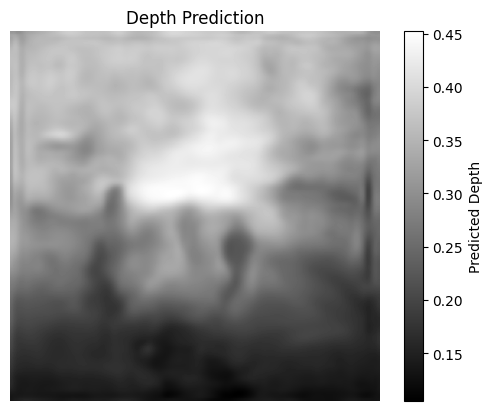

In [10]:
import matplotlib.pyplot as plt

plt.imshow(depth_map.squeeze().cpu().numpy(), cmap='gray')
plt.colorbar(label="Predicted Depth")
plt.title("Depth Prediction")
plt.axis("off")
plt.show()


In [11]:
import os
import io
import glob
import logging
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from tips.pytorch import image_encoder
from tips.scenic.utils import feature_viz

# ──────────────────────
# Configure logging
# ──────────────────────
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')

# ──────────────────────
# Constants
# ──────────────────────
IMAGE_SIZE = 448
PATCH_SIZE = 14
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ──────────────────────
# Inference Pipeline
# ──────────────────────
class TipsDepthInferencePipeline:
    def __init__(self, image_encoder_ckpt, decoder_ckpt):
        self.image_encoder_ckpt = image_encoder_ckpt
        self.decoder_ckpt = decoder_ckpt

        self.encoder = self._load_image_encoder()
        self.decoder = self._load_decoder()

        self.transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize((0, 0, 0), (1, 1, 1)),
        ])

    def _load_image_encoder(self):
        logging.info("Loading TIPS image encoder...")
        weights = dict(np.load(self.image_encoder_ckpt, allow_pickle=False))
        for k in weights:
            weights[k] = torch.tensor(weights[k])

        model = image_encoder.vit_small(
            img_size=IMAGE_SIZE,
            patch_size=PATCH_SIZE,
            ffn_layer='mlp',
            block_chunks=0,
            init_values=1.0,
            interpolate_antialias=True,
            interpolate_offset=0.0,
        )
        model.load_state_dict(weights)
        model.eval().to(DEVICE)
        return model

    def _load_decoder(self):
        logging.info("Loading DPT decoder...")
        decoder = DPTDepthDecoder(embed_dim=384, channels=256).to(DEVICE)
        decoder.load_state_dict(torch.load(self.decoder_ckpt, map_location=DEVICE))
        decoder.eval()
        return decoder

    def infer_depth(self, image_path):
        logging.info(f"Processing image: {image_path}")
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            output = self.encoder(image_tensor)
            cls_token = output[0][:, 0:1, :]      # [B, 1, D]
            spatial_tokens = output[2]           # [B, HW, D]
            all_tokens = torch.cat([spatial_tokens, cls_token], dim=1)

            B, N, D = all_tokens.shape
            H = W = int((N - 1) ** 0.5)
            spatial = all_tokens[:, :-1, :].view(B, H, W, D).permute(0, 3, 1, 2)

            depth_map = self.decoder(spatial)    # [B, 1, 256, 256]
            return depth_map.squeeze(0).squeeze(0).cpu().numpy()

    def visualize_depth(self, depth_map, cmap='gray'):
        plt.figure(figsize=(6, 6))
        plt.imshow(depth_map, cmap=cmap)
        plt.colorbar(label="Predicted Depth")
        plt.title("DPT Depth Map")
        plt.axis("off")
        plt.show()


# ──────────────────────
# DPT Decoder
# ──────────────────────
class ReassembleLayer(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor):
        super().__init__()
        self.project = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.resample = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=False)

    def forward(self, x):
        return self.resample(self.project(x))

class FusionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.residual_conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, x, skip):
        if x.shape[-2:] != skip.shape[-2:]:
            skip = F.interpolate(skip, size=x.shape[-2:], mode='bilinear', align_corners=False)
        x = self.residual_conv(x + skip)
        return self.upsample(x)

class DPTDepthDecoder(nn.Module):
    def __init__(self, embed_dim=384, channels=256):
        super().__init__()
        self.reassemble_layers = nn.ModuleList([
            ReassembleLayer(embed_dim, channels, scale_factor=4),
            ReassembleLayer(embed_dim, channels, scale_factor=2),
            ReassembleLayer(embed_dim, channels, scale_factor=1),
        ])
        self.fusion_blocks = nn.ModuleList([
            FusionBlock(channels),
            FusionBlock(channels),
        ])
        self.output_head = nn.Sequential(
            nn.Conv2d(channels, channels // 2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // 2, 1, 1)
        )

    def forward(self, spatial_feats):
        feats = [re_layer(spatial_feats) for re_layer in self.reassemble_layers]
        x = self.fusion_blocks[0](feats[-1], feats[-2])
        x = self.fusion_blocks[1](x, feats[-3])
        x = self.output_head(x)
        return F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)


[INFO] Loading TIPS image encoder...
[INFO] Loading DPT decoder...
[INFO] Processing image: /usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/images/inputs/basketball/color/00000001.jpg


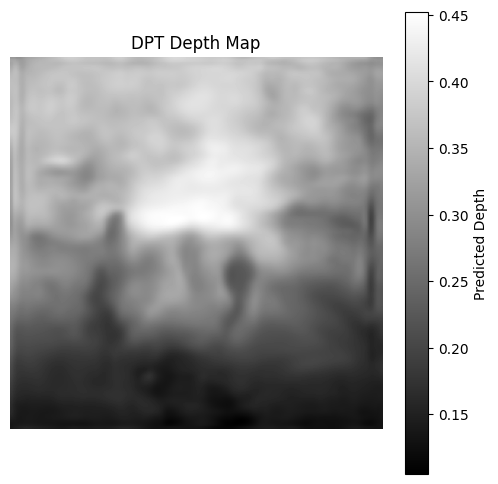

In [12]:


# ──────────────────────
# Example Usage
# ──────────────────────
if __name__ == "__main__":
    image_path = "/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/images/inputs/basketball/color/00000001.jpg"
    decoder_ckpt = "/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/checkpoints/dpt_decoder_epoch_19.pth"
    image_ckpt = "/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/tips/pytorch/checkpoints/tips_oss_s14_highres_distilled_vision.npz"

    pipeline = TipsDepthInferencePipeline(image_ckpt, decoder_ckpt)
    depth = pipeline.infer_depth(image_path)
    pipeline.visualize_depth(depth)
